In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.random.seed(42)


import seaborn as sns
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

In [2]:
bd_rh = pd.read_csv("C:/Users/fabio/Desktop/Sandbox/bd/HR-Employee-Attrition.csv")

bd_rh = bd_rh.replace({"Yes":1, "No":0})
bd_rh = bd_rh.replace({"Travel_Rarely":1, "Non-Travel":0, "Travel_Frequently":2})

bd_rh = bd_rh.apply(pd.to_numeric, errors='ignore')
# bd_rh = pd.get_dummies(bd_rh)

In [3]:
#New Features

#Em todo tempo de casa, teve uma mudança de cargo?
bd_rh["Promotion"]= bd_rh.YearsAtCompany - bd_rh.YearsInCurrentRole
bd_rh["Promotion"] = bd_rh["Promotion"].map(bd_rh["YearsSinceLastPromotion"]>0,1).astype("int")
bd_rh["Promotion"] = bd_rh["Promotion"].map(bd_rh["YearsSinceLastPromotion"]!=1,0).astype("int")

#Em todo tempo de casa, trabalhou com pelo menos dois gestores??
bd_rh["ChangMng"]= bd_rh.YearsAtCompany - bd_rh.YearsWithCurrManager
bd_rh["ChangMng"] = bd_rh["ChangMng"].map(bd_rh["ChangMng"]>=1,1).astype("int")

    
bd_rh.head(2)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Promotion,ChangMng
0,41,1,1,1102,Sales,1,2,Life Sciences,1,1,...,0,8,0,1,6,4,0,5,1,1
1,49,0,2,279,Research & Development,8,1,Life Sciences,1,2,...,1,10,3,3,10,7,1,7,0,1


In [4]:
#####################################################################################
bdcorr = bd_rh[['YearsWithCurrManager','YearsInCurrentRole','YearsAtCompany', 
              'PerformanceRating', 'PercentSalaryHike', 
              'JobLevel','MonthlyIncome','YearsSinceLastPromotion', 
              'Promotion', 'ChangMng','Attrition']]

cols_analysis = ['Attrition','JobLevel']
corr = bdcorr.groupby(cols_analysis, as_index= True).corr()

#####################################################################################
## Plot func
def attr_matrix(corr, cols_analysis,level_target): 
    corr = round(corr,2)
    #PLOT
    fig, axs = plt.subplots(1, 2, figsize=(16, 9))
    print(f"Matriz de correlações para {cols_analysis[0]} x {cols_analysis[1]}: {level_target}")
    
    #Gráficos
    # Principais razões para pedir demissão (casos em que houve attrition)
    sns.heatmap (corr.xs(level_target, level=1).xs(1, level=0), annot=True,ax=axs[0])
    axs[0].set_title('Razões para pedir demissão')

    # Principais razoes para ficar no trabalho (casos em que não houve attrition)
    sns.heatmap (corr.xs(level_target, level=1).xs(0, level=0), annot=True,ax=axs[1])
    axs[1].set_title('Razoes para ficar no trabalho')

    # Ajustar o layout para evitar sobreposição de títulos
    plt.tight_layout()

    # Mostrar o gráfico
    plt.show()
    
    
    
    
    
    
    
    
# #####################################################################################
# # # Dropdown com os jobs levels
level_target = widgets.Dropdown(options=corr.index.get_level_values(1).unique())
# Função para ser chamada com o valor selecionado
def update(level_target):
    attr_matrix(corr, cols_analysis, level_target)
# Widget interativo com o dropdown
widgets.interact(update, level_target=level_target)

interactive(children=(Dropdown(description='level_target', options=(1, 2, 3, 4, 5), value=1), Output()), _dom_…

<function __main__.update(level_target)>

In [5]:
# Nível de correlação -> 
# Correlação Forte (0.7) são quase as mesmas razoes para ficar exceto no caso de muitos anos na mesma posição e mesmo gestor
# Correlação moderada (0.5) Combinação para pedir demissão(insatisfação com YrsSinceLastPromo(Quanto mais tempo com o mesmo gerente e role),YearsatCompany)

corr2 = corr[(abs(corr)>0.7) & (abs(corr)<1) ]

# #####################################################################################
# # # Dropdown com os jobs levels
level_target = widgets.Dropdown(options=corr.index.get_level_values(1).unique())
# Função para ser chamada com o valor selecionado
def update(level_target):
    attr_matrix(corr2, cols_analysis, level_target)
# Widget interativo com o dropdown
widgets.interact(update, level_target=level_target)

interactive(children=(Dropdown(description='level_target', options=(1, 2, 3, 4, 5), value=1), Output()), _dom_…

<function __main__.update(level_target)>

----------------------------------------

In [6]:
## Modelo Preditivos -> Classificação 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report #,confusion_matrix 

base_modelos = pd.get_dummies(bd_rh)

#Target: Attrition 

X = base_modelos.drop(columns = "Attrition")
y = base_modelos.Attrition

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
 #Comparando modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

# Dicionário para armazenar os modelos e suas acurácias
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'k-NN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

# Avaliar todos os modelos
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name}: Acurácia = {accuracy:.2f}')
#     print(classification_report(y_test, y_pred))

# best_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

Logistic Regression: Acurácia = 0.87
Decision Tree: Acurácia = 0.76
Random Forest: Acurácia = 0.88
SVM: Acurácia = 0.87
k-NN: Acurácia = 0.85
Gradient Boosting: Acurácia = 0.88
XGBoost: Acurácia = 0.87
Naive Bayes: Acurácia = 0.77


In [15]:
## Modelo de GridSearch para tunar os parametros do modelo escolhido
from sklearn.model_selection import GridSearchCV

# Definindo a grade de hiperparâmetros a serem testados
param_grid = {
    'n_estimators': [50, 100, 150],                           # Número de árvores na floresta
    'max_depth': [None, 5, 10, 15],                           # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],                          # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4, 6],                         # Mínimo de amostras em um nó folha
    'max_features': ['auto', 'sqrt', 'log2'],                 # Número de características a considerar para a divisão
    'bootstrap': [True, False],                               # Se amostras são retiradas com substituição
    'class_weight': [None, 'balanced_subsample'],             # Pesos das classes para lidar com dados desbalanceados
    'random_state': [42]                                       # Semente para reprodutibilidade dos resultados
}

# Grid Search com Cross Validation
grid_search = GridSearchCV(estimator=RandomForestClassifier()
                           , param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Melhor conjunto de hiperparâmetros
print(f"Melhores parâmetros: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


KeyboardInterrupt: 

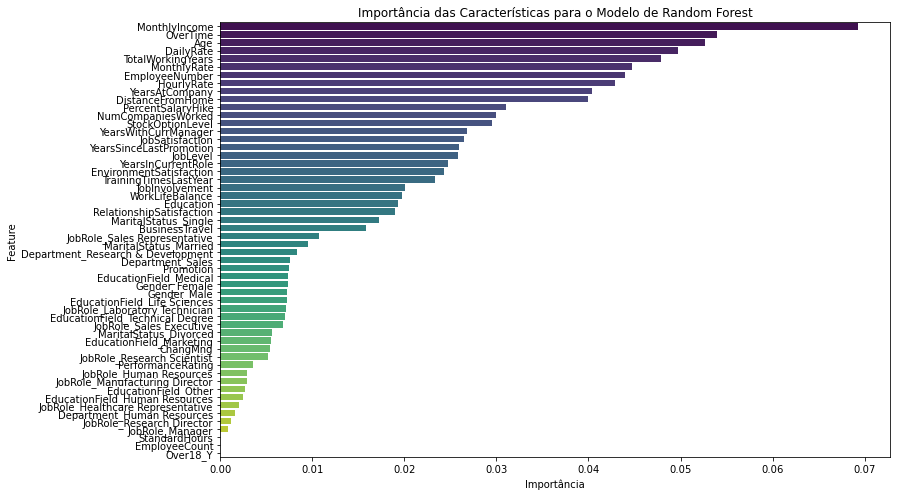

In [10]:
# best_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
importances = best_model.feature_importances_

# Obtendo os nomes das features
feature_names = X_train.columns

# Criar um DataFrame com as importâncias das características
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenar o DataFrame pelas importâncias das características em ordem decrescente
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualização das Importâncias das Features

# Gráfico de barras das importâncias das características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Importância')
plt.title('Importância das Características para o Modelo de Random Forest')
plt.show()
